In [451]:
import sys
sys.path.append("./planet-wind-rt/")

import argparse
from planet_wind_constants import cs1,cs2,nu1,nu2,nu3,c,natural_gamma
from scipy.special import wofz
import time
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
import planet_wind_utils_v6 as pw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import deepdish as dd
import seaborn as sns
from astropy.io import ascii
#mpl.use('Agg')

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16

Omega_orb = 1.28241e-05
a = 8.228e+11
rp = 6.72e9

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [404]:
SCALE = 0.2

# Convergence Studies, Appendix

In [452]:
def plot_list(filelist,labellist,pal,offset=0.0,legtitle=None,labely=True,labelx=True):
    for i,fn in enumerate(filelist):
        sp = ascii.read(fn,names=['lambda','flux'])
        plt.plot(sp['lambda'],sp['flux']+offset*i,label=labellist[i],color=pal[i],lw=2)

    plt.legend(loc='lower left',frameon=True,title=legtitle)
    plt.axvline(10830.33977, color='black', ls=':')
    plt.axvline(10830.2501, color='black', ls=':')
    plt.axvline(10829.09114, color='black', ls=':')
    if labelx:
        plt.xlabel(r'wavelength [$\AA$]')
    if labely:
        plt.ylabel('relative flux')
        
def plot_list_planetframe(filelist,labellist,pal,alist,offset=0.0):
    vorb = np.sqrt( (6.67e-8*orb['m1'][0])/orb['sep'][0] )
    vplanet = np.sin(np.array(alist))*vorb
    lw = np.linspace(1+len(filelist)*0.75,1,len(filelist))
    for i,fn in enumerate(filelist):
        sp = ascii.read(fn,names=['lambda','flux'])
        plt.axhline(1+offset*i,color=pal[i],lw=2,ls=':',zorder=0)
        plt.plot(sp['lambda']*(1+vplanet[i]/c.c),sp['flux']+offset*i,label=labellist[i],color=pal[i],lw=lw[i],ls='-',alpha=0.8)

    aa = np.linspace(-0.3,0.3,1000)
    
    plt.axvline(10830.33977, color='black', ls=':')
    plt.axvline(10830.2501, color='black', ls=':')
    plt.axvline(10829.09114, color='black', ls=':')
    plt.xlabel(r'planet-frame wavelength [$\AA$]')
    plt.xlim(10828,10831.5)

reading orbit file for planet wind simulation...


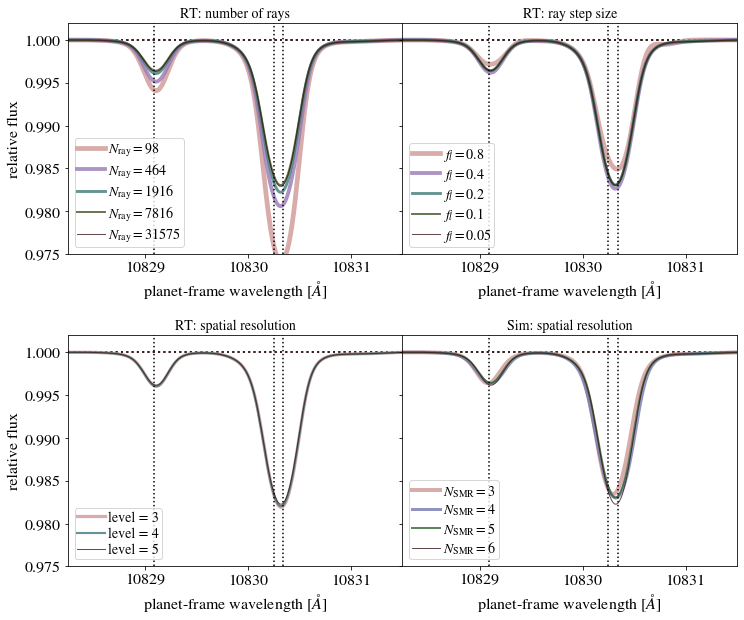

In [456]:
orb = pw.read_trackfile("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/pm_trackfile.dat")

plt.figure(figsize=(12,10))

# N rays
plt.subplot(221)
filelist = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc12_Nr0.1_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc25_Nr0.1_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc50_Nr0.1_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.1_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc200_Nr0.1_spectrum24_a0.06.txt"]
            

labellist = [r"$N_{\rm ray} = 98$",r"$N_{\rm ray} = 464$",
             r"$N_{\rm ray} = 1916$",r"$N_{\rm ray} = 7816$",
             r"$N_{\rm ray} = 31575$"]

#pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=1,reverse=False)
pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=2,reverse=False)

plt.title("RT: number of rays",fontsize=14)
plot_list_planetframe(filelist,labellist,pal,[0.06,0.06,0.06,0.06,0.06,0.06])
plt.ylim(0.975,1.002)
plt.xlim(10828.25,10831.5)
plt.legend()
plt.ylabel("relative flux")
#plt.grid()


# fl
plt.subplot(222)

filelist = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.8_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.4_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.2_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.1_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.05_spectrum24_a0.06.txt"]
            
            
labellist = [r"$f_l = 0.8$",
           r"$f_l = 0.4$",
            r"$f_l = 0.2$",
            r"$f_l = 0.1$",
            r"$f_l = 0.05$"]

pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=2,reverse=False)


plt.title("RT: ray step size",fontsize=14)
plot_list_planetframe(filelist,labellist,pal,[0.06,0.06,0.06,0.06,0.06])
plt.ylim(0.975,1.002)
plt.xlim(10828.25,10831.5)
#plt.ylabel("relative flux")
plt.yticks(visible=False)
plt.legend(loc='lower left')
#plt.grid()



# rt level
plt.subplot(223)
filelist = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A6/PW_W107.out1.00030.athdf_s0.2_l3_Nmc100_Nr0.05_spectrum24_a0.06.txt",
           "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A6/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a0.06.txt" ,
           "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A6/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.05_spectrum24_a0.06.txt"]

labellist = [r"level = 3",r"level = 4",r"level = 5"]

pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=2,reverse=False)


plt.title("RT: spatial resolution",fontsize=14)
plot_list_planetframe(filelist,labellist,pal,[0.06,0.06,0.06])
plt.ylim(0.975,1.002)
plt.xlim(10828.25,10831.5)
plt.ylabel("relative flux")
plt.legend(loc='lower left')
#plt.grid()






plt.subplot(224)

filelist = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A3/PW_W107.out1.00030.athdf_s0.2_l3_Nmc100_Nr0.05_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A4/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.05_spectrum24_a0.06.txt",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A6/PW_W107.out1.00030.athdf_s0.2_l5_Nmc100_Nr0.05_spectrum24_a0.06.txt"]
    
    
labellist = [r"$N_{\rm SMR} = 3$",r"$N_{\rm SMR} = 4$",r"$N_{\rm SMR} = 5$",r"$N_{\rm SMR} = 6$"]

#pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=1,reverse=False)
pal = sns.cubehelix_palette(len(filelist),light=0.66,rot=2,reverse=False)

plt.title("Sim: spatial resolution",fontsize=14)
plot_list_planetframe(filelist,labellist,pal,[0.06,0.06,0.06,0.06])
plt.ylim(0.975,1.002)
plt.xlim(10828.25,10831.5)

plt.yticks(visible=False)
plt.legend(loc='lower left')

#plt.grid()

plt.subplots_adjust(wspace=0,hspace=0.35)
plt.savefig("figures-rev/convergence_combined.pdf",bbox_inches='tight')

# Full-Frame Snapshot

In [457]:
def sliceplotinset():
    fig,ax = plt.subplots(figsize=(7,6))

    lim=2e12
    plt.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
               pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
               pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:])),
               cmap='magma',vmin=-22,vmax=-16,shading='nearest',rasterized=True)


    cb = plt.colorbar(aspect=30,pad=0.02,label=r'$\log_{10}\left(\rho \right) \ \ [{\rm g \ cm}^{-3}]$',shrink=0.9,extend='both')
    cb.solids.set_edgecolor("face")

    plt.axis('equal')
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)


    axins = ax.inset_axes([0.01, 0.01, 0.34, 0.34])
    axins.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
                 pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
                 pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:])),
                 cmap='magma',vmin=-22,vmax=-16,shading='nearest',rasterized=True)
    # sub region of the original image
    ilim = 1.5e11
    axins.set_aspect('equal')
    axins.set_xlim((-ilim-a)/c.au, (ilim-a)/c.au)
    axins.set_ylim(-ilim/c.au, ilim/c.au)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins)


    plt.xlabel(r'$x \ \ [\rm {au}]$')
    plt.ylabel(r'$y \ \ [\rm {au}]$')

reading orbit file for planet wind simulation...
read_data...reading file /Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...


<ipython-input-458-d4d2c8a25d25>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[i].pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
<ipython-input-458-d4d2c8a25d25>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axins.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,


reading orbit file for planet wind simulation...
read_data...reading file /Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/PW_W107.out1.00030.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...
reading orbit file for planet wind simulation...
read_data...reading file /Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/PW_W107.out1.00030.athdf
 ...file read, constructing arrays
 ...gamma= 1.6666666666666667
...getting cartesian arrays...


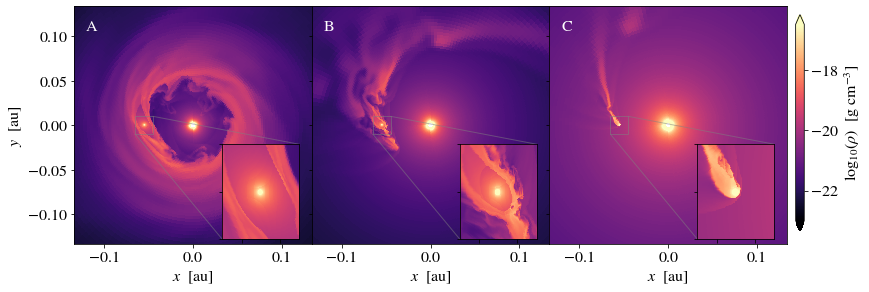

In [458]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5),sharey=True)
lim=2e12
mylevel = 3


base_dir_list = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/",
                 "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/",
                 "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/"]
snapshot = "PW_W107.out1.00030.athdf"

labellist = ['A','B','C']

for i in range(3):
    orb = pw.read_trackfile(base_dir_list[i]+"pm_trackfile.dat")
    dblank=pw.ar.athdf(base_dir_list[i]+snapshot,quantities=[],level=mylevel,subsample=True)
    x2sliceval = dblank['x2v'][np.argmin(np.abs(dblank['x2v']-np.pi/2) )]

    
    d = pw.read_data(base_dir_list[i]+snapshot,orb,
                 level=mylevel,x2_min=x2sliceval,x2_max=x2sliceval)

    
    
    
    
    im = ax[i].pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
               pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
               pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:]*SCALE)),
               cmap='magma',vmin=-23,vmax=-16.5,shading='flat',rasterized=True)


    #cb = plt.colorbar(im,aspect=30,pad=0.02,label=r'$\log_{10}\left(\rho \right) \ \ [{\rm g \ cm}^{-3}]$',shrink=0.9,extend='both')
    #cb.solids.set_edgecolor("face")

    ax[i].set_aspect('equal')
    ax[i].set_xlim(-lim/c.au,lim/c.au)
    ax[i].set_ylim(-lim/c.au,lim/c.au)


    axins = ax[i].inset_axes([0.57, 0.02, 0.43, 0.4])
    axins.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
                 pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
                 pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:]*SCALE)),
                 cmap='magma',vmin=-23,vmax=-16.5,shading='flat',rasterized=True)
    # sub region of the original image
    ilim = 1.5e11
    axins.set_aspect('equal')
    axins.set_xlim((-ilim-a)/c.au, (ilim-a)/c.au)
    axins.set_ylim(-ilim/c.au, ilim/c.au)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax[i].indicate_inset_zoom(axins)

    ax[i].annotate(labellist[i],(0.05,0.9),xycoords='axes fraction',color='w')
    
    ax[i].set_xlabel(r'$x \ \ [\rm {au}]$')
    ax[0].set_ylabel(r'$y \ \ [\rm {au}]$')
    
    
#ax[0].set_title(r'A')
#ax[1].set_title(r'B')
#ax[2].set_title(r'C')
fig.subplots_adjust(wspace=0.0,right=0.95)
cax = fig.add_axes([0.96, 0.21, 0.01, 0.6])
cb=fig.colorbar(im,cax=cax,label=r'$\log_{10}\left(\rho \right) \ \ [{\rm g \ cm}^{-3}]$',extend='both')
cb.solids.set_edgecolor("face")
plt.savefig("figures-rev/density_slice_aniso_combined.pdf",bbox_inches='tight',dpi=300)

# RT Fig

In [459]:
def Voigt(x, alpha, gamma):
    sigma = alpha / np.sqrt(2.0*np.log(2.0))
    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2.0)))/sigma/np.sqrt(2.0*np.pi)

def make_rt_plot(mytitle):
    plt.figure(figsize=(6,10))


    plt.subplot(211)
    lim = 19
    im=plt.pcolormesh((d['x']+a)/rp,d['y']/rp, np.log10(d['nhe3']) ,shading='nearest',cmap = 'magma',
                      vmin=-8,vmax=3,
                      rasterized=True )
    plt.contour((d['x']+a)/rp,d['y']/rp,  np.log10(np.cumsum(d['nhe3']*sigma_he3*d['dr'],axis=1) ) ,
                cmap = 'Blues',levels=np.linspace(-3,0,4) )

    cb=plt.colorbar(im,label=r'$n_{\rm He} f_{3}$ [cm$^{-3}$]',shrink=0.9,extend='both')
    cb.solids.set_edgecolor("face")
    plt.axis('equal')
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.xticks(visible=False)
    #plt.xlabel('$x_p / r_p$')
    plt.ylabel('$y_p / r_p$')
    plt.title(mytitle)



    plt.subplot(212)
    im=plt.pcolormesh((d['x']+a)/rp,d['y']/rp, d['vx']/1.e5 ,shading='nearest',
                      cmap = 'Spectral',#'RdBu_r',
                      vmin=-30,vmax=30,rasterized=True )
    plt.contour((d['x']+a)/rp,d['y']/rp,  np.log10(np.cumsum(d['nhe3']*sigma_he3*d['dr'],axis=1) ) ,
                cmap = 'Blues',levels=np.linspace(-3,0,4) )

    cb=plt.colorbar(im,label=r'$v_{\rm los}$ [km s$^{-1}$]',shrink=0.9,extend='both')
    cb.solids.set_edgecolor("face")
    plt.axis('equal')
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    #plt.xticks(visible=False)
    plt.xlabel('$x_p / r_p$')
    plt.ylabel('$y_p / r_p$')

    plt.subplots_adjust(hspace=0)
    
    

<ipython-input-460-663f0488a8e6>:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1=ax[0,i].pcolormesh((d['x']+a)/rp,d['y']/rp, np.log10(np.where(d['nhe3']<1.e-15,1.e-15,d['nhe3'])) ,shading='nearest',cmap = 'magma',
<ipython-input-460-663f0488a8e6>:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2=ax[1,i].pcolormesh((d['x']+a)/rp,d['y']/rp, d['vx']/1.e5 ,shading='nearest',cmap = 'RdBu_r',vmin=-40,vmax=40,rasterized=True )


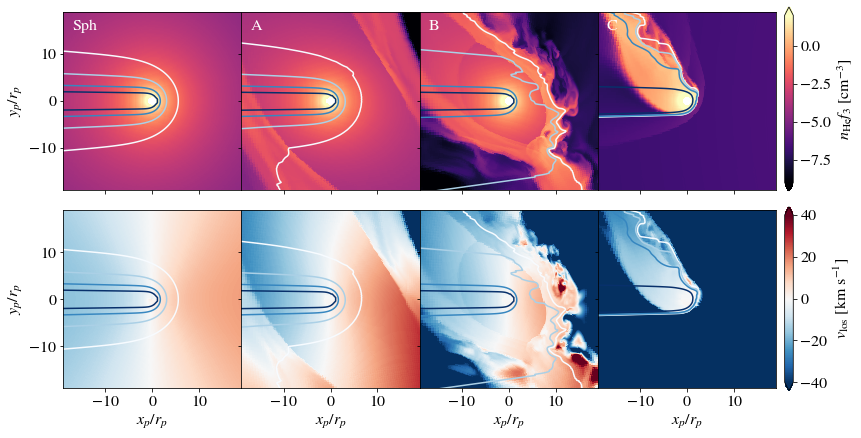

In [460]:
filelist = ["/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf.rt_s0.2parker.h5",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf.rt_s0.2.h5",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/PW_W107.out1.00030.athdf.rt_s0.2.h5",
            "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/PW_W107.out1.00030.athdf.rt_s0.2.h5"]

fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(12,7.3),sharey=True,sharex=True)


labellist = ['Sph','A','B','C']

for i in range(4):
    d = dd.io.load(filelist[i])
    d['rp'] = np.sqrt((d['x']+a)**2 + d['y']**2+d['z']**2)
    d['nhe3'] = np.where(d['rp']<rp,np.nan,d['nhe3'])
    da1 = np.sqrt(2.0*np.log(2.0))*nu1 * np.sqrt(0.25*c.kB*d['temp']/c.mp)/c.c
    sigma_he3 = (cs1+cs2)*Voigt(0,da1,natural_gamma) 
        
    lim = 19
    im1=ax[0,i].pcolormesh((d['x']+a)/rp,d['y']/rp, np.log10(np.where(d['nhe3']<1.e-15,1.e-15,d['nhe3'])) ,shading='nearest',cmap = 'magma',
                      vmin=-9,vmax=2,
                      rasterized=True )
    ax[0,i].contour((d['x']+a)/rp,d['y']/rp,  np.nan_to_num(np.log10(np.cumsum(d['nhe3']*sigma_he3*d['dr'],axis=1) ),nan=100) ,
                cmap = 'Blues',levels=np.linspace(-3,0,4) )

    #cb=plt.colorbar(im,label=r'$n_{\rm He} f_{3}$ [cm$^{-3}$]',shrink=0.9,extend='both')
    #cb.solids.set_edgecolor("face")
    ax[0,i].set_aspect('equal')
    ax[0,i].set_xlim(-lim,lim)
    ax[0,i].set_ylim(-lim,lim)
    #ax[i].xticks(visible=False)
    #plt.xlabel('$x_p / r_p$')
    #ax[0,i].set_ylabel('$y_p / r_p$')
    #ax[i].title(mytitle)
    
    ax[0,i].annotate(labellist[i],(0.05,0.9),xycoords='axes fraction',color='w')



    im2=ax[1,i].pcolormesh((d['x']+a)/rp,d['y']/rp, d['vx']/1.e5 ,shading='nearest',cmap = 'RdBu_r',vmin=-40,vmax=40,rasterized=True )
    ax[1,i].contour((d['x']+a)/rp,d['y']/rp,  np.nan_to_num(np.log10(np.cumsum(d['nhe3']*sigma_he3*d['dr'],axis=1) ),nan=100), 
                cmap = 'Blues',levels=np.linspace(-3,0,4) )

    #cb=plt.colorbar(im,label=r'$v_{\rm los}$ [km s$^{-1}$]',shrink=0.9,extend='both')
    #cb.solids.set_edgecolor("face")
    ax[1,i].set_aspect('equal')
    ax[1,i].set_xlim(-lim,lim)
    ax[1,i].set_ylim(-lim,lim)
    #plt.xticks(visible=False)
    ax[1,i].set_xlabel('$x_p / r_p$')
    

ax[0,0].set_ylabel('$y_p / r_p$')
ax[1,0].set_ylabel('$y_p / r_p$')
fig.subplots_adjust(hspace=0.0,wspace=0.,right=0.95)
cax = fig.add_axes([0.96, 0.52, 0.01, 0.35])
cb=fig.colorbar(im1,cax=cax,label=r'$n_{\rm He} f_{3}$ [cm$^{-3}$]',extend='both')
cb.solids.set_edgecolor("face")
cax = fig.add_axes([0.96, 0.14, 0.01, 0.35])
cb=fig.colorbar(im2,cax=cax,label=r'$v_{\rm los}$ [km s$^{-1}$]',extend='both')
cb.solids.set_edgecolor("face")

#ax[0,0].set_title(r'$\dot M_* = 10^{11}$ g s$^{-1}$')
#ax[0,1].set_title(r'$\dot M_* = 10^{12}$ g s$^{-1}$')
#ax[0,2].set_title(r'$\dot M_* = 10^{13}$ g s$^{-1}$')



plt.savefig("figures-rev/rt_combined.pdf",bbox_inches='tight',dpi=300)

# Spectra 

<ipython-input-462-3f97f4aa7645>:25: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
<ipython-input-462-3f97f4aa7645>:25: RuntimeWarning: invalid value encountered in log10
  im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
<ipython-input-462-3f97f4aa7645>:25: UserWarning: The following kwargs were not used by contour: 'rasterized'
  im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
<ipython-input-462-3f97f4aa7645>:25: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
<ipython-input-462-3f97f4aa7645>:25: RuntimeWarning: invalid value encountered in log10
  im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
<ipython-input-462-3f97f4a

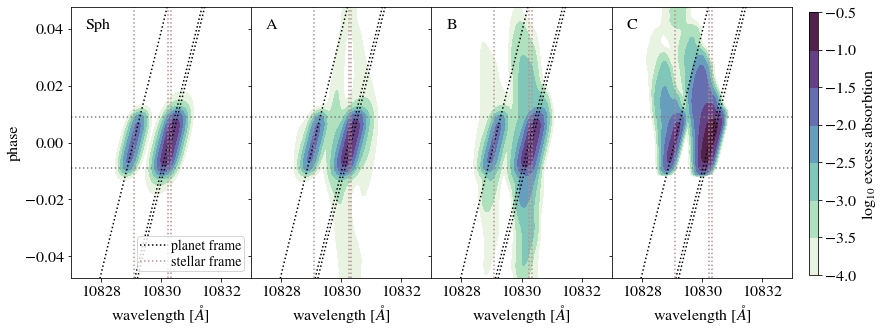

In [462]:
# colormap series
def make_filelist(filestem,parker=False):
    angles = np.linspace(-0.3,0.3,61)
    filelist = []
    for i,aa in enumerate(angles):
        if parker:
            fn = filestem + str(np.round(aa,2)) + "_parker.txt"
        else:
            fn = filestem + str(np.round(aa,2)) + ".txt"
        filelist.append(fn)
    return filelist

def plot_absorbtion_phase(filestem,parker=False):
    mycm = sns.cubehelix_palette(1024,start=1,light=0.99,hue=1,rot=-0.8,as_cmap=True)
    filelist = make_filelist(filestem,parker=parker)
    sp = ascii.read(filelist[0],names=['lambda','flux'])
    x = sp['lambda']
    y = -np.linspace(-0.3,0.3,61)/(2*np.pi)
    xx,yy = np.meshgrid(x,y)
    zz = np.zeros_like(xx)

    for i,fn in enumerate(filelist):
        sp = ascii.read(fn,names=['lambda','flux'])
        zz[i,:] = sp['flux']
    im = plt.contourf(xx,yy,np.log10( (1-zz) ),cmap=mycm,levels=np.linspace(-4,-0.5,8),rasterized=True)
    #im = plt.pcolormesh(xx,yy,(1-zz)*100 ,cmap=mycm,vmin=0,vmax=10,rasterized=True)
    al = np.linspace(-0.3,0.3,1000)
    vorb = np.sqrt( (6.67e-8*orb['m1'][0])/orb['sep'][0] )
    vplanet = np.sin(al)*vorb
    plt.plot(10830.33977*(1+vplanet/c.c),al/(2*np.pi), color='black', ls=':',label='planet frame')
    plt.plot(10830.2501*(1+vplanet/c.c),al/(2*np.pi), color='black', ls=':')
    plt.plot(10829.09114*(1+vplanet/c.c),al/(2*np.pi), color='black', ls=':')
    plt.axvline(10830.33977, color='RosyBrown', ls=':',label='stellar frame')
    plt.axvline(10830.2501, color='RosyBrown', ls=':')
    plt.axvline(10829.09114, color='RosyBrown', ls=':')
    plt.axhline(4.67e10/orb['sep'][0]/(2*np.pi),ls=':',color='grey')  
    plt.axhline(-4.67e10/orb['sep'][0]/(2*np.pi),ls=':',color='grey')  
    return im

fig=plt.figure(figsize=(12,5))
plt.subplot(141)
stemA = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a"
imA = plot_absorbtion_phase(stemA,parker=True)
#plt.colorbar()
plt.ylabel('phase')
plt.xlabel(r'wavelength [$\AA$]')
plt.annotate('Sph',(10827.5,0.04))
plt.legend(frameon=True,loc='lower right')

plt.subplot(142)
stemA = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a"
imA = plot_absorbtion_phase(stemA)
#plt.colorbar()
#plt.ylabel('phase')
plt.yticks(visible=False)
plt.xlabel(r'wavelength [$\AA$]')
plt.annotate('A',(10827.5,0.04))
#plt.legend(frameon=True,loc='lower right')

plt.subplot(143)
stemB = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a"
imB = plot_absorbtion_phase(stemB)
plt.yticks(visible=False)
plt.xlabel(r'wavelength [$\AA$]')
plt.annotate('B',(10827.5,0.04))

plt.subplot(144)
stemC = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_a"
imC = plot_absorbtion_phase(stemC)
plt.yticks(visible=False)
plt.xlabel(r'wavelength [$\AA$]')
plt.annotate('C',(10827.5,0.04))

plt.subplots_adjust(wspace=0,right=0.96)
cax = fig.add_axes([0.98, 0.135, 0.01, 0.73])
cb=fig.colorbar(imC,cax=cax,label=r'$\log_{10}$ excess absorbtion')
#cb=fig.colorbar(imC,cax=cax,label=r'percent excess absorbtion',extend='max')
cb.solids.set_edgecolor("face")


plt.savefig("figures-rev/absorbtion_colormap_log.pdf",bbox_inches='tight',dpi=300)

# Light Curves from Spectra (EW)

In [463]:
def get_EW(fn):
    sp = ascii.read(fn,names=['lambda','flux'])
    dlam = sp['lambda'][1]-sp['lambda'][0]
    return np.sum(1-sp['flux'])*dlam


def write_EWT(mydir,fileroot,alist,parker=False):
    ew = np.zeros_like(alist)
    for i,aa in enumerate(alist):
        if parker:
            fn = mydir+fileroot+"_a"+str(np.round(aa,2))+"_parker.txt"
        else:
            fn = mydir+fileroot+"_a"+str(np.round(aa,2))+".txt"
        ew[i]=get_EW(fn)

    from astropy.table import Table
    ewt = Table([np.round(alist,2),ew],names=['angle','EW'])
    ewt['phase'] = -ewt['angle']/(2*np.pi)
    if parker:
        ascii.write(ewt,mydir+fileroot+"_parker_EWT.dat",overwrite=True)
    else:
        ascii.write(ewt,mydir+fileroot+"_EWT.dat",overwrite=True)
    

In [464]:
mydir = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/"
fileroot = "PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24"
alist = np.linspace(-0.3,0.3,61)
write_EWT(mydir,fileroot,alist)

mydir = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/"
write_EWT(mydir,fileroot,alist)

mydir = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/"
write_EWT(mydir,fileroot,alist)

In [465]:
mydir = "/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/"
fileroot = "PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24"
alist = np.linspace(-0.3,0.3,61)
write_EWT(mydir,fileroot,alist,parker=True)

137.3175098663633
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude               mean                stddev      
    ------------------- ---------------------- ------------------
    0.03226624683707077 -0.0018384396181643687 0.8430087397771303
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean               stddev      
    ------------------- -------------------- ------------------
    0.03111393751296892 -0.01854047075491208 0.8496386263186367
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean               stddev      
    ------------------- -------------------- ------------------
    0.03352405925636089 -0.06438144370777162 0.9328603990564251
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean              stddev      
    -----------------

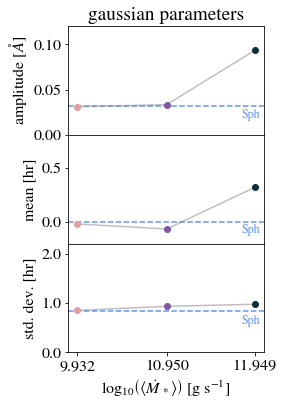

In [466]:
Phr = 2*np.pi*np.sqrt(orb['sep'][0]**3 / (6.67e-8*orb['m1'][0])) / 3600.
print(Phr)

lmds=np.log10(np.array([8549264940.60866,89142452519.24234,888181934611.1714]))

ewtAP = ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_parker_EWT.dat")

ewtA = ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_EWT.dat")
ewtB = ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_EWT.dat")
ewtC = ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/PW_W107.out1.00030.athdf_s0.2_l4_Nmc100_Nr0.05_spectrum24_EWT.dat")


from astropy.modeling import models, fitting
import scipy.stats


# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=0, stddev=1.6)
fit_g = fitting.LevMarLSQFitter()

gP = fit_g(g_init, ewtAP['phase']*Phr, ewtAP['EW'])
print(gP)

gA = fit_g(g_init, ewtA['phase']*Phr, ewtA['EW'] )
print(gA)

gB = fit_g(g_init, ewtB['phase']*Phr, ewtB['EW']  )
print(gB)

gC = fit_g(g_init, ewtC['phase']*Phr, ewtC['EW']  )
print(gC)


lmd = [11,12,13]
amp = [gA.amplitude.value,gB.amplitude.value,gC.amplitude.value]
mean = [gA.mean.value,gB.mean.value,gC.mean.value]
stddev = [gA.stddev.value,gB.stddev.value,gC.stddev.value]






#pal = sns.cubehelix_palette(n_colors=3,start=1.3,rot=2,hue=1,light=0.6)
pal = sns.cubehelix_palette(n_colors=3,start=2.2,rot=0.8,hue=1,light=0.7)

plt.figure(figsize=(3.5,6))

plt.subplot(311)
plt.title("gaussian parameters")
plt.plot(lmds,amp,'-',color='grey',alpha=0.5)
for i in range(3):
    plt.plot(lmds[i],amp[i],'o',color=pal[i])

plt.xticks(visible=False)
plt.ylim(0,0.12)
plt.axhline(gP.amplitude.value,ls='--',color='CornflowerBlue',zorder=0)
plt.annotate("Sph",(11.8,gP.amplitude.value-0.013),fontsize=12,color='CornflowerBlue')
#plt.grid()
plt.ylabel(r"amplitude [$\AA$]")

plt.subplot(312)
plt.plot(lmds,mean,'-',color='grey',alpha=0.5)
for i in range(3):
    plt.plot(lmds[i],mean[i],'o',color=pal[i])
    
plt.axhline(gP.mean.value,ls='--',color='CornflowerBlue',zorder=0)
plt.annotate("Sph",(11.8,gP.mean.value-0.1),fontsize=12,color='CornflowerBlue')

plt.xticks(visible=False)
plt.ylim(-0.2,0.8)
#plt.grid()
plt.ylabel(r"mean [hr]")

plt.subplot(313)
plt.plot(lmds,stddev,'-',color='grey',alpha=0.5)
for i in range(3):
    plt.plot(lmds[i],stddev[i],'o',color=pal[i])
    
plt.axhline(gP.stddev.value,ls='--',color='CornflowerBlue',zorder=0)
plt.annotate("Sph",(11.8,gP.stddev.value-0.26),fontsize=12,color='CornflowerBlue')

plt.ylim(0,2.2)
#plt.grid()
plt.ylabel(r"std. dev. [hr]")
plt.xticks(lmds)
plt.xlabel(r"$\log_{10}\left( \langle\dot M_*\rangle \right)$ [g s$^{-1}$]")
plt.yticks([0.0,1.0,2.0],labels=[0.0,1.0,2.0])

plt.subplots_adjust(hspace=0)


plt.savefig("figures-rev/gauss_param.pdf",bbox_inches='tight',dpi=300)

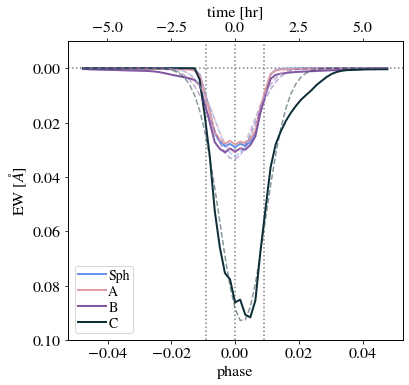

In [467]:
plt.figure(figsize=(6,5.5))
plt.ylim(0.1,-0.01)
plt.axhline(0,ls=':',color='grey')
plt.axvline(0,ls=':',color='grey')
plt.axvline(4.67e10/orb['sep'][0]/(2*np.pi),ls=':',color='grey')  
plt.axvline(-4.67e10/orb['sep'][0]/(2*np.pi),ls=':',color='grey')
plt.ylabel(r"EW [$\AA$]")
plt.xlabel("phase")




alpha = 0.6

plt.plot(ewtAP['phase'],ewtAP['EW'],color='CornflowerBlue',label=r'Sph',lw=2)
plt.plot(ewtA['phase'],ewtA['EW'],color=pal[0],label=r'A',lw=2)
plt.plot(ewtB['phase'],ewtB['EW'],color=pal[1],label=r'B',lw=2)
plt.plot(ewtC['phase'],ewtC['EW'],color=pal[2],label=r'C',lw=2)

xp = ewtA['phase']
plt.plot(xp,gP(xp*Phr),color='CornflowerBlue',ls='--',alpha=0.5)
plt.plot(xp,gA(xp*Phr),color=pal[0],ls='--',alpha=0.5)
plt.plot(xp,gB(xp*Phr),color=pal[1],ls='--',alpha=0.5)
plt.plot(xp,gC(xp*Phr),color=pal[2],ls='--',alpha=0.5)

plt.legend(loc=0,frameon=True)

par = plt.twiny()
par.set_xlim(np.min(ewtA['phase'])*Phr,np.max(ewtA['phase'])*Phr)
par.set_xlabel('time [hr]')

plt.savefig("figures-rev/EW_LC.pdf",bbox_inches='tight',dpi=300)

In [468]:
def print_stats(hst):
    hst['MdotP'] = np.gradient(hst['0-scalar'])/np.gradient(hst['time'])-hst['md_m_p']
    hst['MdotS'] = np.gradient(hst['1-scalar'])/np.gradient(hst['time'])-hst['md_m_s']
    
    sel = hst['time']>1.e6
    #plt.plot(hst['time'][sel],hst['MdotS'][sel])
    print("mdot_p (mean) =",np.mean(hst['MdotP'][sel])*SCALE)
    print("mdot_s (mean) =",np.mean(hst['MdotS'][sel])*SCALE)
    print("\n")

print("A")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)

print("A3")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A3/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)

print("A4")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A4/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)

print("A6")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/A/A6/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)

print("B")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/B/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)

print("C")
hst=ascii.read("/Users/morganmacleod/DATA/athenaruns/w107_sw_paper/C/PW_W107.hst",
          names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','0-scalar','1-scalar','md_m_p','md_m_s'])
print_stats(hst)



A
mdot_p (mean) = 9103870660.468765
mdot_s (mean) = 17098529881.21732


A3
mdot_p (mean) = 9306648289.946184
mdot_s (mean) = 16779701716.23967


A4
mdot_p (mean) = 9621467333.21673
mdot_s (mean) = 16886965914.133854


A6
mdot_p (mean) = 9177941143.928946
mdot_s (mean) = 17095088773.214384


B
mdot_p (mean) = 8699067427.360533
mdot_s (mean) = 178284905038.48468


C
mdot_p (mean) = 7246036361.5116825
mdot_s (mean) = 1776363869222.3428




<ipython-input-468-c0e46d576e2b>:2: RuntimeWarning: invalid value encountered in true_divide
  hst['MdotP'] = np.gradient(hst['0-scalar'])/np.gradient(hst['time'])-hst['md_m_p']
<ipython-input-468-c0e46d576e2b>:3: RuntimeWarning: invalid value encountered in true_divide
  hst['MdotS'] = np.gradient(hst['1-scalar'])/np.gradient(hst['time'])-hst['md_m_s']


In [374]:
4.67e10/orb['sep'][0]/(2*np.pi)

0.009009134354413955

# momentum ratios 

In [469]:
rhos = 4.16e-15
Ms = 1.36e33
Rs = 4.67e10
Lamdas = 15

rhop = 7.78e-16
Mp = 1.82e29
Rp = 6.71e9
Lamdap = 5

momratioA = (rhop/rhos)*(Mp/Ms)*(Rs/Rp)*(Lamdas/Lamdap)*np.exp(Lamdas-Lamdap)
print("A:",momratioA)

rhos = 4.16e-14
momratioB = (rhop/rhos)*(Mp/Ms)*(Rs/Rp)*(Lamdas/Lamdap)*np.exp(Lamdas-Lamdap)
print("B:",momratioB)

rhos = 4.16e-14
rhop = 1.46299e-15
momratioC = (rhop/rhos)*(Mp/Ms)*(Rs/Rp)*(Lamdas/Lamdap)*np.exp(Lamdas-Lamdap)
print("C:",momratioC)

A: 11.510102208254997
B: 1.1510102208254995
C: 2.164417021806552


In [473]:
"""
Simulation A:
    
    ==========================================================
==========   BC INFO         =============================
==========================================================
rho_surface (star) = 4.15672e-15
lambda (star) = 15
press_surface (star) =0.538548
sound speed surface (star) =1.1383e+07
estimated mdot (star) = 1e+11
rho_surface (planet) = 7.78186e-16
lambda (planet) = 5
aniso_heat (planet) =0
press_surface (planet) =0.000281712
sound speed surface (star) =228079
estimated mdot (planet) = 5e+10
"""

print("rho star = ",4.15672e-15*SCALE)
print("P star = ",0.538548*SCALE)
print("rho planet = ",7.78186e-16*SCALE)
print("P planet = ",0.000281712*SCALE)


rho star =  8.313440000000001e-16
P star =  0.10770960000000002
rho planet =  1.556372e-16
P planet =  5.63424e-05
